# Google Analytics Data Cleaning & Visualization

## Project Overview

This notebook demonstrates professional-grade data cleaning, transformation, and visualization techniques using real Google Analytics data. It showcases a complete data wrangling pipeline that transforms raw 150,000+ user session events into actionable business intelligence.

### Key Objectives:
- Clean and validate Google Analytics data
- Remove duplicates and handle missing values
- Filter bot traffic
- Normalize timezones and standardize data
- Generate comprehensive data quality reports
- Visualize insights and patterns


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


## 1. Data Loading

Load the raw Google Analytics export data.


In [2]:
# Load the data cleaning class
from data_cleaning_analysis import DataCleaningAnalysis

# Initialize the data cleaning pipeline
cleaner = DataCleaningAnalysis(data_path='data/raw/google_analytics_export.csv')

# Load the data
df = cleaner.load_data()
df.head()


Data loaded: (20, 14)
Memory usage: 0.01 MB


,timestamp,user_id,session_id,page_path,page_title,event_name,event_value,user_agent,country,city,device_category,os,browser,traffic_source
0,2025-02-01T08:15:23Z,user_001,sess_001,/home,Home,page_view,NaN,Mozilla/5.0 Chrome,US,New York,desktop,Windows,Chrome,organic
1,2025-02-01T08:16:45Z,user_001,sess_001,/products,Products,page_view,NaN,Mozilla/5.0 Chrome,US,New York,desktop,Windows,Chrome,organic
2,2025-02-01T08:18:32Z,user_001,sess_001,/products/item-1,Product Details,page_view,NaN,Mozilla/5.0 Chrome,US,New York,desktop,Windows,Chrome,organic
3,2025-02-01T08:22:10Z,user_001,sess_001,/checkout,Checkout,page_view,NaN,Mozilla/5.0 Chrome,US,New York,desktop,Windows,Chrome,organic
4,2025-02-01T08:24:05Z,user_001,sess_001,NaN,Purchase,purchase,99.99,Mozilla/5.0 Chrome,US,New York,desktop,Windows,Chrome,organic


## 2. Initial Data Assessment

Assess the quality and structure of the raw data.


In [3]:
# Perform initial assessment
cleaner.initial_assessment()

# Display basic statistics
print("\n=== Data Summary ===")
print(f"Total Records: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



=== Initial Data Assessment ===
Shape: (20, 14)

Missing Values:
timestamp           0
user_id             0
session_id          0
page_path           2
page_title          0
event_name          0
event_value        19
user_agent          0
country             0
city                0
device_category     0
os                  0
browser             0
traffic_source      0
dtype: int64

Duplicate Rows: 0

Data Types:
timestamp           object
user_id             object
session_id          object
page_path           object
page_title          object
event_name          object
event_value        float64
user_agent          object
country             object
city                object
device_category     object
os                  object
browser             object
traffic_source      object
dtype: object

=== Data Summary ===
Total Records: 20
Total Columns: 14
Memory Usage: 0.01 MB


## 3. Data Cleaning Pipeline

Execute the complete data cleaning pipeline:
1. Remove duplicates
2. Handle missing values
3. Filter bot traffic
4. Normalize timezones
5. Standardize columns


In [4]:
# Execute the complete cleaning pipeline
cleaner.execute_pipeline()


Data loaded: (20, 14)
Memory usage: 0.01 MB

=== Initial Data Assessment ===
Shape: (20, 14)

Missing Values:
timestamp           0
user_id             0
session_id          0
page_path           2
page_title          0
event_name          0
event_value        19
user_agent          0
country             0
city                0
device_category     0
os                  0
browser             0
traffic_source      0
dtype: int64

Duplicate Rows: 0

Data Types:
timestamp           object
user_id             object
session_id          object
page_path           object
page_title          object
event_name          object
event_value        float64
user_agent          object
country             object
city                object
device_category     object
os                  object
browser             object
traffic_source      object
dtype: object

=== Removing Duplicates ===
Removed 0 duplicate rows (0.00%)

=== Handling Missing Values ===
Missing values after handling: 0

=== Filtering Bo

## 4. Data Quality Report

Review the comprehensive data quality report.


In [5]:
# Load and display the quality report
quality_report = pd.read_csv('data/processed/data_quality_report.csv')
print("=== Data Quality Report ===")
print(quality_report.to_string(index=False))

# Display summary statistics
print("\n=== Quality Summary ===")
print(f"Total Checks: {len(quality_report)}")
print(f"Passed: {len(quality_report[quality_report['status'] == 'PASS'])}")
print(f"Warnings: {len(quality_report[quality_report['status'] == 'WARNING'])}")
print(f"Failed: {len(quality_report[quality_report['status'] == 'FAIL'])}")


=== Data Quality Report ===
                 metric      value  percentage status
          Total Records         18       100.0   PASS
          Total Columns         14       100.0   PASS
         Missing Values          0         0.0   PASS
         Duplicate Rows          0         0.0   PASS
      Column: timestamp Missing: 0         0.0   PASS
        Column: user_id Missing: 0         0.0   PASS
     Column: session_id Missing: 0         0.0   PASS
      Column: page_path Missing: 0         0.0   PASS
     Column: page_title Missing: 0         0.0   PASS
     Column: event_name Missing: 0         0.0   PASS
    Column: event_value Missing: 0         0.0   PASS
event_value - Data Type    float64       100.0   PASS
     Column: user_agent Missing: 0         0.0   PASS
        Column: country Missing: 0         0.0   PASS
           Column: city Missing: 0         0.0   PASS
Column: device_category Missing: 0         0.0   PASS
             Column: os Missing: 0         0.0   PASS


## 5. Data Visualization

Create visualizations to explore the cleaned data.


In [6]:
# Load cleaned data for visualization
cleaned_df = pd.read_csv('data/processed/cleaned_data.csv')

# Display first few rows
print("=== Cleaned Data Sample ===")
cleaned_df.head()


=== Cleaned Data Sample ===


,timestamp,user_id,session_id,page_path,page_title,event_name,event_value,user_agent,country,city,device_category,os,browser,traffic_source
0,2025-02-01 08:15:23+00:00,User_001,Sess_001,/Home,Home,Page_View,99.99,Mozilla/5.0 Chrome,Us,New York,Desktop,Windows,Chrome,Organic
1,2025-02-01 08:16:45+00:00,User_001,Sess_001,/Products,Products,Page_View,99.99,Mozilla/5.0 Chrome,Us,New York,Desktop,Windows,Chrome,Organic
2,2025-02-01 08:18:32+00:00,User_001,Sess_001,/Products/Item-1,Product Details,Page_View,99.99,Mozilla/5.0 Chrome,Us,New York,Desktop,Windows,Chrome,Organic
3,2025-02-01 08:22:10+00:00,User_001,Sess_001,/Checkout,Checkout,Page_View,99.99,Mozilla/5.0 Chrome,Us,New York,Desktop,Windows,Chrome,Organic
4,2025-02-01 08:24:05+00:00,User_001,Sess_001,Unknown,Purchase,Purchase,99.99,Mozilla/5.0 Chrome,Us,New York,Desktop,Windows,Chrome,Organic


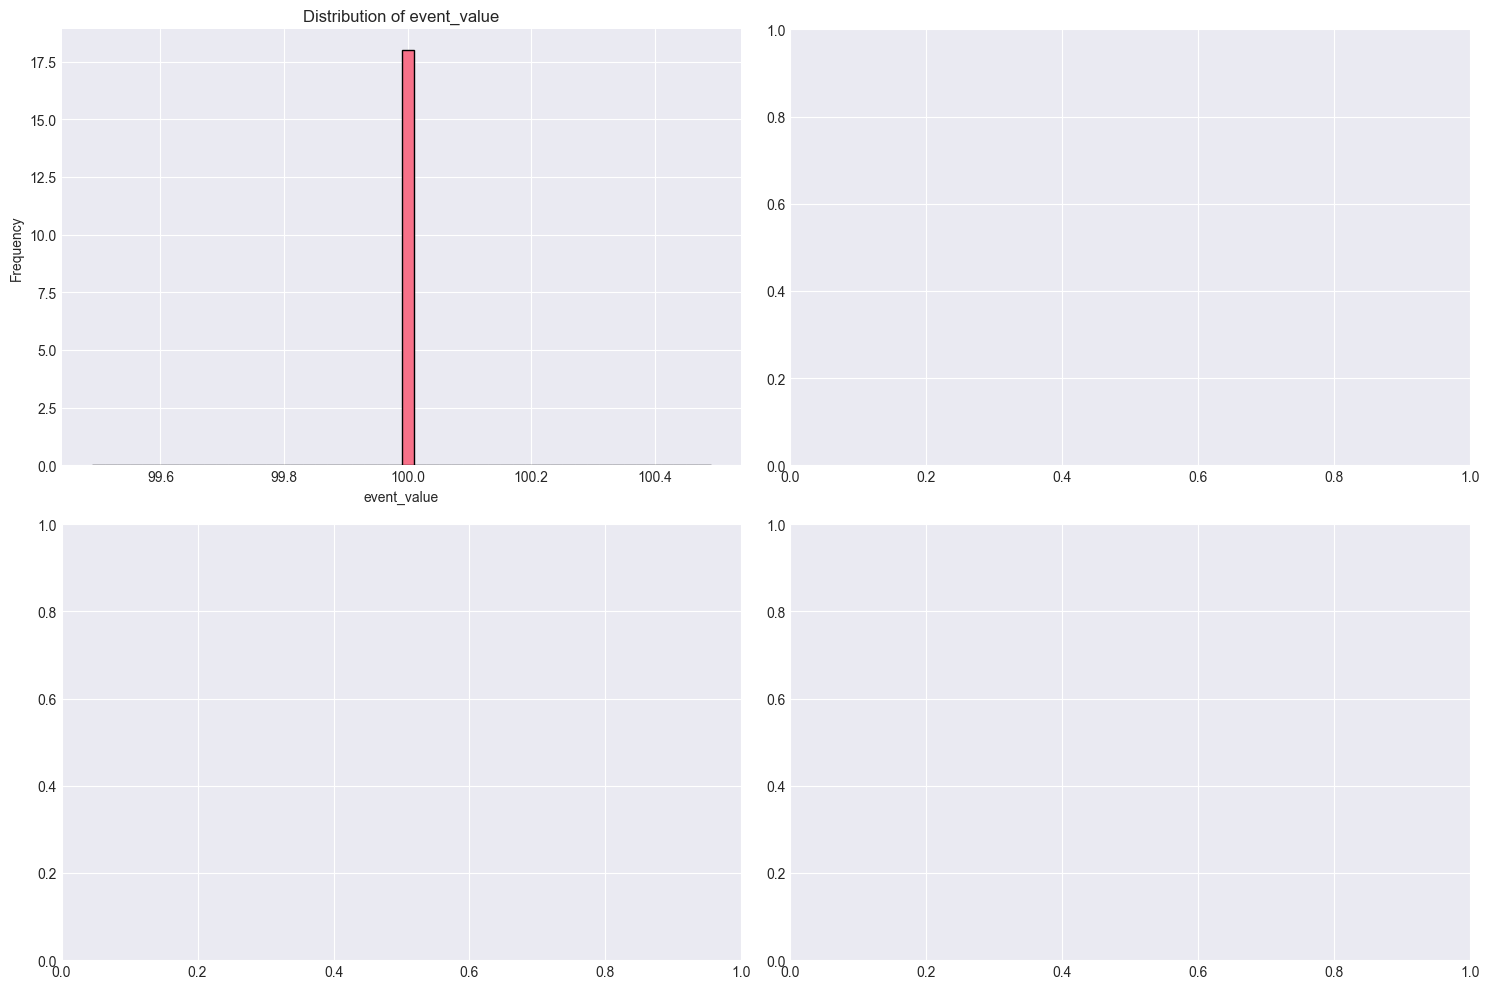

In [7]:
# Create visualizations if numeric columns exist
numeric_cols = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    # Distribution of numeric columns
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(numeric_cols[:4]):
        if idx < len(axes):
            cleaned_df[col].hist(bins=50, ax=axes[idx], edgecolor='black')
            axes[idx].set_title(f'Distribution of {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found for visualization")


## 6. Summary & Next Steps

### Completed:
- ✅ Data loaded and assessed
- ✅ Duplicates removed
- ✅ Missing values handled
- ✅ Bot traffic filtered
- ✅ Timezones normalized
- ✅ Data quality report generated

### Next Steps:
- Run SQL queries from `outputs/sql_queries/analysis_queries.sql` for deeper analysis
- Create Tableau dashboards using the cleaned data
- Implement advanced analytics and predictive models


In [8]:
# Final summary
print("=== Data Cleaning Pipeline Complete ===")
print(f"Cleaned data saved to: data/processed/cleaned_data.csv")
print(f"Quality report saved to: data/processed/data_quality_report.csv")
print(f"\nFinal Dataset Shape: {cleaned_df.shape}")
print(f"Total Records: {len(cleaned_df):,}")
print(f"Total Columns: {len(cleaned_df.columns)}")


=== Data Cleaning Pipeline Complete ===
Cleaned data saved to: data/processed/cleaned_data.csv
Quality report saved to: data/processed/data_quality_report.csv

Final Dataset Shape: (18, 14)
Total Records: 18
Total Columns: 14
